In [1]:
import matplotlib.pyplot as plt
import torch
import torchvision

from torch import nn
from torchvision import transforms
from helper_functions import set_seeds

In [2]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [3]:
!wget https://github.com/garythung/trashnet/raw/master/data/dataset-resized.zip -O dataset-resized.zip

--2025-02-01 16:22:29--  https://github.com/garythung/trashnet/raw/master/data/dataset-resized.zip
Resolving github.com (github.com)... 140.82.121.4
Connecting to github.com (github.com)|140.82.121.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/garythung/trashnet/master/data/dataset-resized.zip [following]
--2025-02-01 16:22:30--  https://raw.githubusercontent.com/garythung/trashnet/master/data/dataset-resized.zip
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.110.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 42834870 (41M) [application/zip]
Saving to: ‘dataset-resized.zip’

dataset-resized.zip 100%[===================>]  40.85M  --.-KB/s    in 0.1s    

2025-02-01 16:22:31 (283 MB/s) - ‘dataset-resized.zip’ saved [42834870/42834870]



In [4]:
!unzip dataset-resized.zip -d dataset

Archive:  dataset-resized.zip
   creating: dataset/dataset-resized/
  inflating: dataset/dataset-resized/.DS_Store  
   creating: dataset/__MACOSX/
   creating: dataset/__MACOSX/dataset-resized/
  inflating: dataset/__MACOSX/dataset-resized/._.DS_Store  
   creating: dataset/dataset-resized/cardboard/
  inflating: dataset/dataset-resized/cardboard/cardboard1.jpg  
  inflating: dataset/dataset-resized/cardboard/cardboard10.jpg  
  inflating: dataset/dataset-resized/cardboard/cardboard100.jpg  
  inflating: dataset/dataset-resized/cardboard/cardboard101.jpg  
  inflating: dataset/dataset-resized/cardboard/cardboard102.jpg  
  inflating: dataset/dataset-resized/cardboard/cardboard103.jpg  
  inflating: dataset/dataset-resized/cardboard/cardboard104.jpg  
  inflating: dataset/dataset-resized/cardboard/cardboard105.jpg  
  inflating: dataset/dataset-resized/cardboard/cardboard106.jpg  
  inflating: dataset/dataset-resized/cardboard/cardboard107.jpg  
  inflating: dataset/dataset-resized/car

In [5]:
# just to make new folders named train, test data
import os
import shutil
from sklearn.model_selection import train_test_split

# Original dataset path
dataset_dir = "dataset/dataset-resized"
# Directories for train and test sets
train_dir = "dataset/train"
test_dir = "dataset/test"

# Create train and test directories if they don't exist
os.makedirs(train_dir, exist_ok=True)
os.makedirs(test_dir, exist_ok=True)

# Define split ratio
test_size = 0.2  # 20% for testing, adjust as needed

# Iterate through each category folder
for category in os.listdir(dataset_dir):
    category_path = os.path.join(dataset_dir, category)
    if os.path.isdir(category_path):  # Check if it's a folder
        # List all files in the category folder
        files = os.listdir(category_path)
        files = [f for f in files if os.path.isfile(os.path.join(category_path, f))]

        # Split the files into train and test sets
        train_files, test_files = train_test_split(files, test_size=test_size, random_state=42)

        # Create subdirectories in train and test folders
        train_category_dir = os.path.join(train_dir, category)
        test_category_dir = os.path.join(test_dir, category)
        os.makedirs(train_category_dir, exist_ok=True)
        os.makedirs(test_category_dir, exist_ok=True)

        # Move files to train folder
        for file in train_files:
            shutil.copy(os.path.join(category_path, file), os.path.join(train_category_dir, file))

        # Move files to test folder
        for file in test_files:
            shutil.copy(os.path.join(category_path, file), os.path.join(test_category_dir, file))

print(f"Dataset split completed. Train data is in '{train_dir}', Test data is in '{test_dir}'.")


Dataset split completed. Train data is in 'dataset/train', Test data is in 'dataset/test'.


In [6]:
# 1. Get pretrained weights for ViT-Base
pretrained_vit_weights = torchvision.models.ViT_B_16_Weights.DEFAULT

# 2. Setup a ViT model instance with pretrained weights
pretrained_vit = torchvision.models.vit_b_16(weights=pretrained_vit_weights).to(device)

# 3. Freeze the base parameters
for parameter in pretrained_vit.parameters():
    parameter.requires_grad = False

# 4. Change the classifier head
class_names = ['cardboard','glass','metal','paper','plastic','trash']

set_seeds()
pretrained_vit.heads = nn.Linear(in_features=768, out_features=len(class_names)).to(device)
# pretrained_vit # uncomment for model output

Downloading: "https://download.pytorch.org/models/vit_b_16-c867db91.pth" to /root/.cache/torch/hub/checkpoints/vit_b_16-c867db91.pth
100%|██████████| 330M/330M [00:02<00:00, 164MB/s]


In [7]:
pip install torchinfo

In [8]:
from torchinfo import summary

# Print a summary using torchinfo (uncomment for actual output)
summary(model=pretrained_vit,
        input_size=(32, 3, 224, 224), # (batch_size, color_channels, height, width)
        # col_names=["input_size"], # uncomment for smaller output
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"]
)

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
VisionTransformer (VisionTransformer)                        [32, 3, 224, 224]    [32, 6]              768                  Partial
├─Conv2d (conv_proj)                                         [32, 3, 224, 224]    [32, 768, 14, 14]    (590,592)            False
├─Encoder (encoder)                                          [32, 197, 768]       [32, 197, 768]       151,296              False
│    └─Dropout (dropout)                                     [32, 197, 768]       [32, 197, 768]       --                   --
│    └─Sequential (layers)                                   [32, 197, 768]       [32, 197, 768]       --                   False
│    │    └─EncoderBlock (encoder_layer_0)                   [32, 197, 768]       [32, 197, 768]       (7,087,872)          False
│    │    └─EncoderBlock (encoder_layer_1)                   [32, 197, 768]       [32, 

#### Notice how only the output layer is trainable, where as, all of the rest of the layers are untrainable (frozen).

In [9]:
# Setup directory paths to train and test images
train_dir = '/content/dataset/train'
test_dir = '/content/dataset/test'

Remember, if you're going to use a pretrained model, it's generally important to ensure your own custom data is transformed/formatted in the same way the data the original model was trained on.

In [10]:
# Get automatic transforms from pretrained ViT weights
pretrained_vit_transforms = pretrained_vit_weights.transforms()
print(pretrained_vit_transforms)

ImageClassification(
    crop_size=[224]
    resize_size=[256]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BILINEAR
)


## And now we've got transforms ready, we can turn our images into DataLoaders using the create_dataloaders()

In [11]:
import os

from torchvision import datasets, transforms
from torch.utils.data import DataLoader

NUM_WORKERS = os.cpu_count()

def create_dataloaders(
    train_dir: str,
    test_dir: str,
    transform: transforms.Compose,
    batch_size: int,
    num_workers: int=NUM_WORKERS
):

  # Use ImageFolder to create dataset(s)
  train_data = datasets.ImageFolder(train_dir, transform=transform)
  test_data = datasets.ImageFolder(test_dir, transform=transform)

  # Get class names
  class_names = train_data.classes

  # Turn images into data loaders
  train_dataloader = DataLoader(
      train_data,
      batch_size=batch_size,
      shuffle=True,
      num_workers=num_workers,
      pin_memory=True,
  )
  test_dataloader = DataLoader(
      test_data,
      batch_size=batch_size,
      shuffle=False,
      num_workers=num_workers,
      pin_memory=True,
  )

  return train_dataloader, test_dataloader, class_names

In [12]:
# Setup dataloaders
train_dataloader_pretrained, test_dataloader_pretrained, class_names = create_dataloaders(train_dir=train_dir,
                                                                                                     test_dir=test_dir,
                                                                                                     transform=pretrained_vit_transforms,
                                                                                                     batch_size=32) # Could increase if we had more samples, such as here: https://arxiv.org/abs/2205.01580 (there are other improvements there too...)


In [13]:
from going_modular import engine

# Create optimizer and loss function
optimizer = torch.optim.Adam(params=pretrained_vit.parameters(),
                             lr=1e-3)
loss_fn = torch.nn.CrossEntropyLoss()

# Train the classifier head of the pretrained ViT feature extractor model
set_seeds()
pretrained_vit_results = engine.train(model=pretrained_vit,
                                      train_dataloader=train_dataloader_pretrained,
                                      test_dataloader=test_dataloader_pretrained,
                                      optimizer=optimizer,
                                      loss_fn=loss_fn,
                                      epochs=50,
                                      device=device)

  0%|          | 0/50 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.8347 | train_acc: 0.7339 | test_loss: 0.5379 | test_acc: 0.8278
Epoch: 2 | train_loss: 0.4347 | train_acc: 0.8644 | test_loss: 0.4311 | test_acc: 0.8605
Epoch: 3 | train_loss: 0.3449 | train_acc: 0.8908 | test_loss: 0.3889 | test_acc: 0.8664
Epoch: 4 | train_loss: 0.2835 | train_acc: 0.9165 | test_loss: 0.3763 | test_acc: 0.8719
Epoch: 5 | train_loss: 0.2438 | train_acc: 0.9272 | test_loss: 0.3523 | test_acc: 0.8839
Epoch: 6 | train_loss: 0.2175 | train_acc: 0.9438 | test_loss: 0.3395 | test_acc: 0.8859
Epoch: 7 | train_loss: 0.1899 | train_acc: 0.9468 | test_loss: 0.3297 | test_acc: 0.8881
Epoch: 8 | train_loss: 0.1696 | train_acc: 0.9590 | test_loss: 0.3245 | test_acc: 0.8901
Epoch: 9 | train_loss: 0.1538 | train_acc: 0.9678 | test_loss: 0.3158 | test_acc: 0.8901
Epoch: 10 | train_loss: 0.1429 | train_acc: 0.9635 | test_loss: 0.3118 | test_acc: 0.8920
Epoch: 11 | train_loss: 0.1286 | train_acc: 0.9746 | test_loss: 0.3098 | test_acc: 0.8920
Epoch: 12 | train_l

pretrained ViT performed far better than our custom ViT model trained from scratch (in the same amount of time).


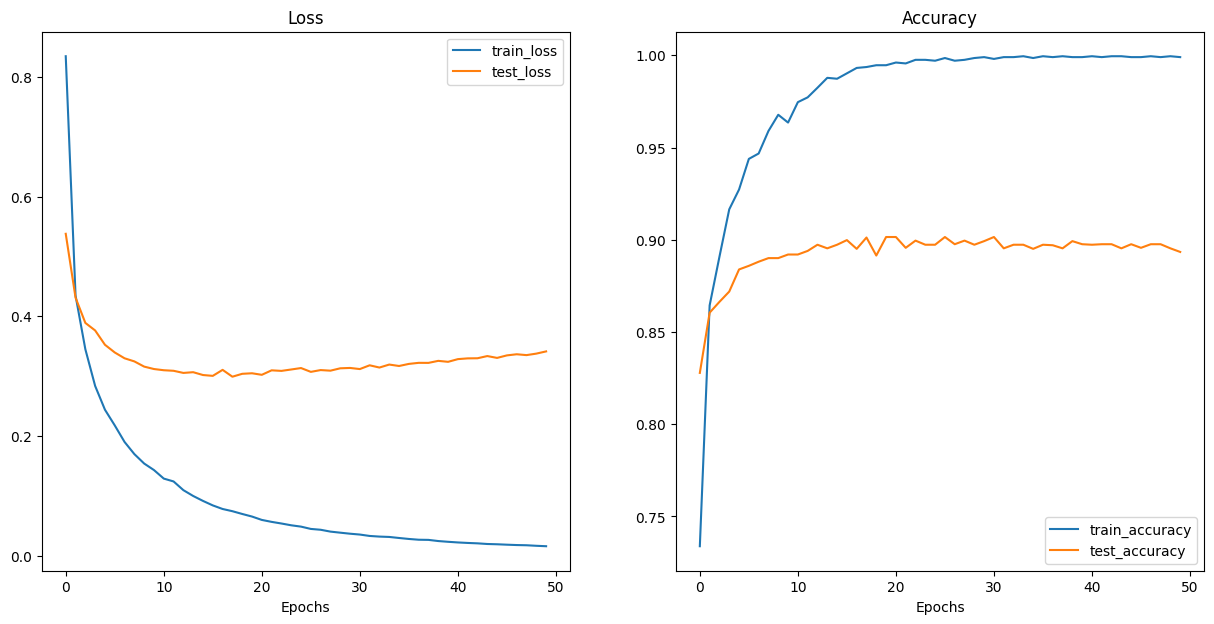

In [14]:
# Plot the loss curves
from helper_functions import plot_loss_curves

plot_loss_curves(pretrained_vit_results)

## That's the power of transfer learning!

We managed to get outstanding results with the same model architecture, except our custom implementation was trained from scratch (worse performance) and this feature extractor model has the power of pretrained weights from ImageNet behind it.

# Let's make Prediction:

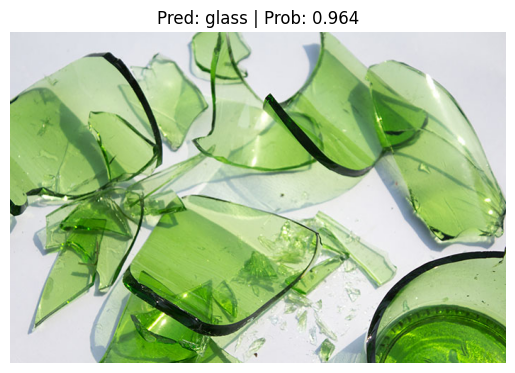

In [15]:
import requests

# Import function to make predictions on images and plot them
from going_modular.predictions import pred_and_plot_image

# Setup custom image path
custom_image_path = "/content/test_image.jpg"

# Predict on custom image
pred_and_plot_image(model=pretrained_vit,
                    image_path=custom_image_path,
                    class_names=class_names)

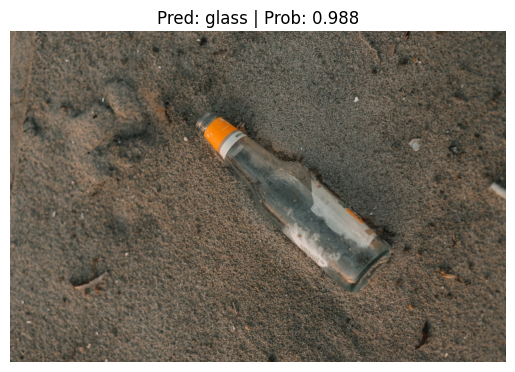

In [16]:
# Import function to make predictions on images and plot them
from going_modular.predictions import pred_and_plot_image

# Setup custom image path
custom_image_path = "/content/test2.jpg"

# Predict on custom image
pred_and_plot_image(model=pretrained_vit,
                    image_path=custom_image_path,
                    class_names=class_names)

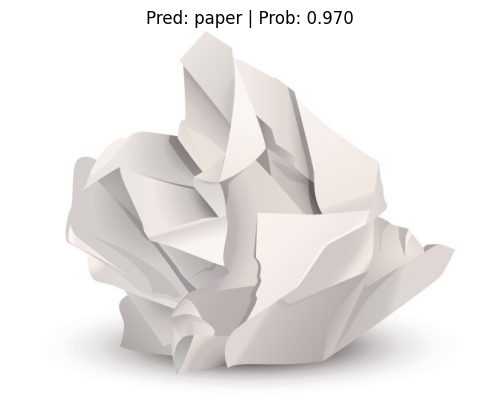

In [17]:
# Import function to make predictions on images and plot them
from going_modular.predictions import pred_and_plot_image

# Setup custom image path
custom_image_path = "/content/test3.jpg"

# Predict on custom image
pred_and_plot_image(model=pretrained_vit,
                    image_path=custom_image_path,
                    class_names=class_names)

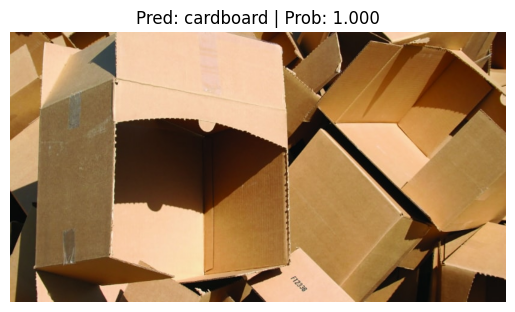

In [18]:
# Import function to make predictions on images and plot them
from going_modular.predictions import pred_and_plot_image

# Setup custom image path
custom_image_path = "/content/test4.jpg"

# Predict on custom image
pred_and_plot_image(model=pretrained_vit,
                    image_path=custom_image_path,
                    class_names=class_names)

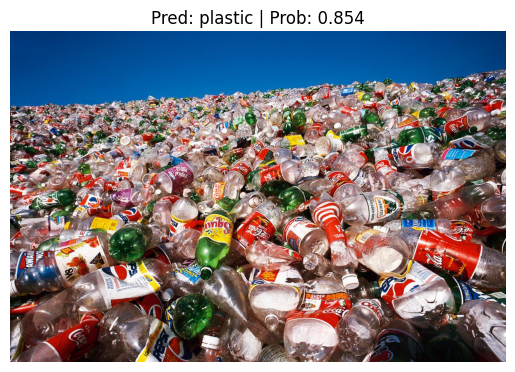

In [19]:
# Import function to make predictions on images and plot them
from going_modular.predictions import pred_and_plot_image

# Setup custom image path
custom_image_path = "/content/test6.jpg"

# Predict on custom image
pred_and_plot_image(model=pretrained_vit,
                    image_path=custom_image_path,
                    class_names=class_names)

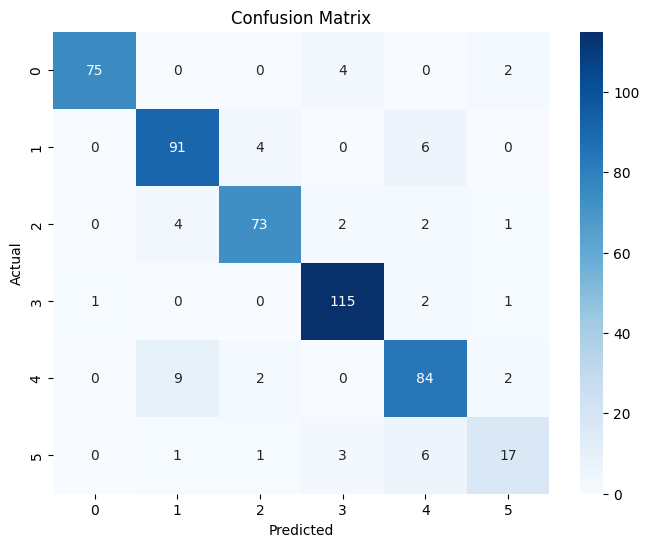

In [27]:
import torch
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming test_loader, model, and device are defined
pretrained_vit.eval()  # Set model to evaluation mode
y_true = []
y_pred = []
test_loader = test_dataloader_pretrained

with torch.no_grad():  # Disable gradient calculation
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = pretrained_vit(inputs)
        _, preds = torch.max(outputs, 1)  # Get the predicted class

        y_true.extend(labels.cpu().numpy())
        y_pred.extend(preds.cpu().numpy())

# Plotting the confusion matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()


In [29]:
from sklearn.metrics import confusion_matrix, classification_report

print("\nClassification Report:\n", classification_report(y_true, y_pred))


Classification Report:
               precision    recall  f1-score   support

           0       0.99      0.93      0.96        81
           1       0.87      0.90      0.88       101
           2       0.91      0.89      0.90        82
           3       0.93      0.97      0.95       119
           4       0.84      0.87      0.85        97
           5       0.74      0.61      0.67        28

    accuracy                           0.90       508
   macro avg       0.88      0.86      0.87       508
weighted avg       0.90      0.90      0.89       508

